In [3]:
import numpy as np
import shapely
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
import rasterio.windows  as rw
from rasterio.enums import Resampling
from rasterio.transform import Affine
from dea import xr_vectorize
from scipy.spatial import cKDTree
from skimage import (color, data, filters, measure, morphology, segmentation,
                     util)
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.stats import gmean
from typing import List, Any
import os
import cv2
import pyproj
import pandas as pd

from sgl_processor_v02 import ProcessorSGL, ProcessorSGLOptions, Window, WindowCollection
from sgl_utils import ROI, ROICollection, Window, WindowCollection, RES, date_with_comma, get_angle, cmap_clouds, cmap_ice
from sgl_utils import find_drainages, drainage2vector, window_dataset, resample_dataset, clip_dataset
import geopandas as gpd

In [4]:
optionsSGL = ProcessorSGLOptions()
optionsSGL.rangestart = "20191201"
optionsSGL.rangeend = "20200331"
processorSGL = ProcessorSGL(optionsSGL)
metas = processorSGL.get_metadata_from_csv(processorSGL.opts.output_folder, ["tile-181", "tile-182", "tile-183"])
coll = processorSGL.create_collection_from_meta("shackleton1920", metas)
rcoll = processorSGL.create_roicollection_from_csv("shackleton")

X=====================================================
PostProcessor started for 20191201 to 20200331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 138 windows created for collection.
     | 16 regions created.


In [5]:
dmgs = processorSGL.get_vectorized_dmgs(coll, print_bool = True, min_dmg_threshold = 0.0, category_bins=5)
dmgs_combined = gpd.GeoDataFrame(pd.concat([d["data"] for d in dmgs]))
dmgs_combined.set_crs(dmgs[0]["data"].crs)
print(f"     | {dmgs_combined.shape[0]:>6d} | with {dmgs_combined.crs}")


=====> Get vectorized dmg.
     |  12514 | tile-181_S1_20191101_20191110_30m_output_10px_dmg.tif
     |  10497 | tile-182_S1_20191101_20191110_30m_output_10px_dmg.tif
     |  11521 | tile-183_S1_20191101_20191110_30m_output_10px_dmg.tif
     |  34532 | with EPSG:3031


In [ ]:
lakeextents = processorSGL.get_vectorized_lakeextents(coll, print_bool = True)
lakeextents_combined = gpd.GeoDataFrame(pd.concat([l["data"] for l in lakeextents]))
lakeextents_combined.set_crs(lakeextents[0]["data"].crs)
print(f"     | {lakeextents_combined.shape[0]:>6d} | with {lakeextents_combined.crs}")

In [ ]:
lakeextents_combined.to_file(os.path.join(processorSGL.opts.output_folder, "L8S2_20191201_20200331_lakeextent.shp"))

In [6]:
drains = gpd.read_file(r"D:\OneDrive\02_Standards\[Code]\01_Projects\ASRP_Antarctic-Remote-Sensing-1\202_OutputSGL\shackleton_sgl_20191201_20200331\L8S2_20191201_20200331_drain.shp")
print(drains.shape)
drains.head(5)

(29, 19)


,index,criteria,window,lake id,type,run,name,area,date-0,sat-0,start-0,end-0,date-1,sat-1,start-1,end-1,day diff,valid,geometry
0,162,tile-1812019-12-161772019-12-26S2S2shrink,0,177.0,shrink,2,tile-181,900.0,2019-12-16,S2,2019-12-11,2019-12-21,2019-12-26,S2,2019-12-21,2019-12-31,10,1,"MULTIPOLYGON (((2551950.000 -472650.000, 25519..."
1,165,tile-1812019-12-164672019-12-26S2S2drain,0,467.0,drain,2,tile-181,42300.0,2019-12-16,S2,2019-12-11,2019-12-21,2019-12-26,S2,2019-12-21,2019-12-31,10,1,"MULTIPOLYGON (((2576310.000 -480390.000, 25763..."
2,172,tile-1812020-01-143132020-01-22L8L8drain,0,313.0,drain,5,tile-181,97200.0,2020-01-14,L8,2020-01-10,2020-01-18,2020-01-22,L8,2020-01-18,2020-01-26,8,1,"MULTIPOLYGON (((2549970.000 -493560.000, 25499..."
3,173,tile-1812020-01-143222020-01-22L8L8drain,0,322.0,drain,5,tile-181,258300.0,2020-01-14,L8,2020-01-10,2020-01-18,2020-01-22,L8,2020-01-18,2020-01-26,8,1,"POLYGON ((2556750.000 -495870.000, 2556780.000..."
4,175,tile-1812020-01-2212282020-01-30L8L8drain,0,1228.0,drain,7,tile-181,3600.0,2020-01-22,L8,2020-01-18,2020-01-26,2020-01-30,L8,2020-01-26,2020-02-03,8,1,"MULTIPOLYGON (((2609070.000 -519180.000, 26090..."


In [57]:
def ckdnearest_SGLfromD(gdSGL, gdD, number_nearest_dmg: int = 1):
    dmg_cats = sorted(gdD["dmg"].unique())
    gdSGL = gdSGL.reset_index(drop=True)
    nSGL = np.array(list(gdSGL["geometry"].centroid.apply(lambda x: (x.x, x.y))))
    gdf_cats = []
    for cat in dmg_cats:
        gdD_cat = gdD[gdD["dmg"] == cat].reset_index(drop=True)
        nD_cat = np.array(list(gdD_cat["geometry"].centroid.apply(lambda x: (x.x, x.y))))
        Dtree = cKDTree(nD_cat)
        dist, idx = Dtree.query(nSGL, k=number_nearest_dmg)
        if idx.ndim > 1:
            gdD_cat_nearest = gdD_cat.iloc[idx[0]].rename(columns={"geometry" : "dmg-geometry"}).reset_index(drop=True)
            gdf_cat = pd.concat(
                [
                    gdSGL.reset_index(drop=True).rename(columns={"geometry" : "sgl-geometry"}),
                    pd.Series(dist.mean(axis = 1), name='dist-dmg-lake'),
                    gdD_cat_nearest
                    
                ], 
                axis=1)
        else:
            gdD_cat_nearest = gdD_cat.iloc[idx].rename(columns={"geometry" : "dmg-geometry"}).reset_index(drop=True)

            gdf_cat = pd.concat(
                [
                    gdSGL.reset_index(drop=True).rename(columns={"geometry" : "sgl-geometry"}),
                    pd.Series(dist, name='dist-dmg-lake'),
                    gdD_cat_nearest,
                    
                ], 
                axis=1)
        gdf_cats.append(gdf_cat)

    return dmg_cats, gdf_cats

def ckdnearest_DfromSGL(gdD, gdSGL, number_nearest_sgl: int = 1):
    dmg_cats = sorted(gdD["dmg"].unique())
    gdSGL = gdSGL.reset_index(drop=True)
    nSGL = np.array(list(gdSGL["geometry"].centroid.apply(lambda x: (x.x, x.y))))
    SGLtree = cKDTree(nSGL)

    gdf_cats = []
    for cat in dmg_cats:
        gdD_cat = gdD[gdD["dmg"] == cat].reset_index(drop=True)
        nD_cat = np.array(list(gdD_cat["geometry"].centroid.apply(lambda x: (x.x, x.y))))
        dist, idx = SGLtree.query(nD_cat, k=number_nearest_sgl)
        gdSGL_cat_nearest = gdSGL.iloc[idx].rename(columns={"geometry" : "sgl-geometry"}).reset_index(drop=True)
        gdf_cat = pd.concat(
                [
                    gdD.reset_index(drop=True).rename(columns={"geometry" : "dmg-geometry"}),
                    pd.Series(dist, name='dist-dmg-lake'),
                    gdSGL_cat_nearest,
                    
                ], 
                axis=1)
        gdf_cats.append(gdf_cat)
    
    return dmg_cats, gdf_cats
        

In [64]:
dmg_cats_sgl, distance_SGLfromD = ckdnearest_SGLfromD(lakeextents_combined, dmgs_combined, number_nearest_dmg = 1)
dmg_cats_d, distance_DfromSGL = ckdnearest_DfromSGL(dmgs_combined, lakeextents_combined, number_nearest_sgl = 1)

In [65]:
dmg_cats_drains, distance_DrainsfromD = ckdnearest_SGLfromD(drains[drains["window"] == 0], dmgs_combined, number_nearest_dmg = 1)
dmg_cats_drains, distance_DfromDrains = ckdnearest_DfromSGL(dmgs_combined, drains[drains["window"] == 0], number_nearest_sgl = 1)

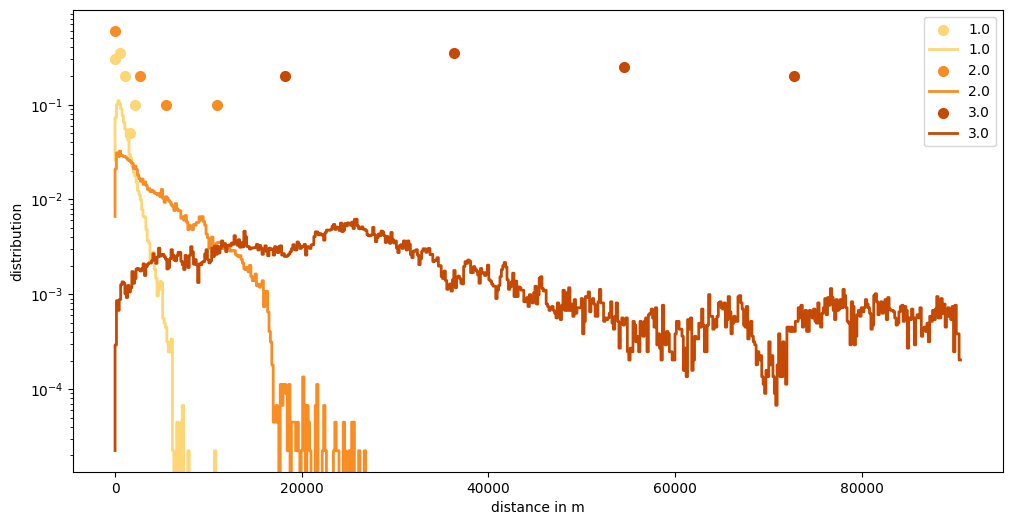

In [66]:
cmap = cm.get_cmap('YlOrBr', 100)

bin_limits_sgl = np.arange(0, max([df["dist-dmg-lake"].max() for df in distance_DrainsfromD]), 300/2)

fig, ax = plt.subplots(figsize = (12, 6))
for i_cat, cat in enumerate(dmg_cats_drains):
    maximum = max(distance_DrainsfromD[i_cat][distance_DrainsfromD[i_cat]["dmg"] == cat]["dist-dmg-lake"])
    bin_limits_drains = np.arange(0, maximum, maximum // 5)
    count_drains, division_drains = np.histogram(distance_DrainsfromD[i_cat][distance_DrainsfromD[i_cat]["dmg"] == cat]["dist-dmg-lake"], bins = bin_limits_drains)
    count_drains_sum = np.array(count_drains).sum()
    if count_drains_sum == 0:
        continue
    ax.scatter(division_drains[:-1], np.array(count_drains) / count_drains_sum, lw = 2, label = f"{cat}", color = cmap((i_cat / len(dmg_cats_drains)) * 0.7 + 0.3))

    count_sgl, division_sgl = np.histogram(distance_SGLfromD[i_cat][distance_SGLfromD[i_cat]["dmg"] == cat]["dist-dmg-lake"], bins = bin_limits_sgl)
    count_sgl_sum = np.array(count_sgl).sum()
    ax.step(division_sgl[:-1], np.array(count_sgl) / count_sgl_sum, lw = 2, label = f"{cat}", color = cmap((i_cat / len(dmg_cats_drains)) * 0.7 + 0.3))

ax.set_xlabel("distance in m")
ax.set_ylabel("distribution")
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.show()

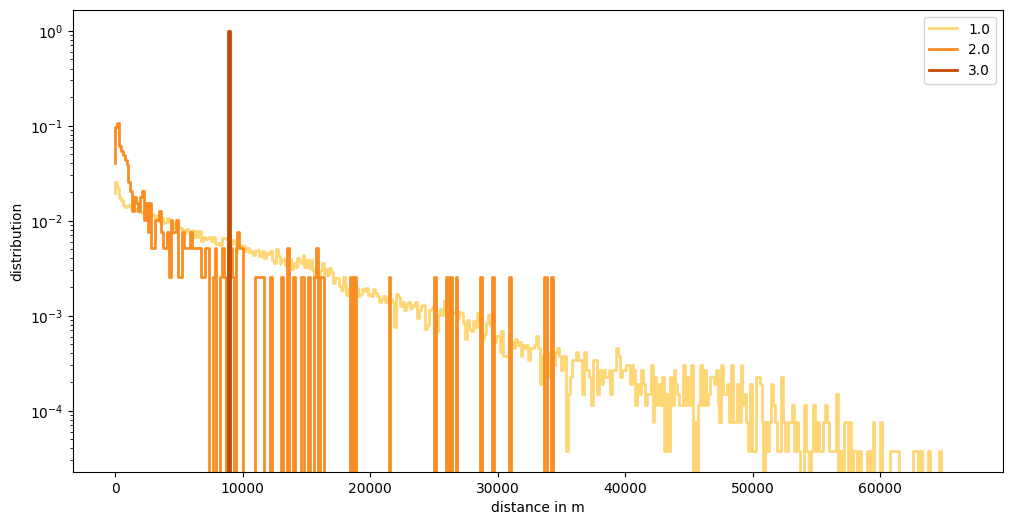

In [68]:
cmap = cm.get_cmap('YlOrBr', 100)

bin_limits_sgl = np.arange(0, max([df["dist-dmg-lake"].max() for df in distance_DfromSGL]), 300/2)

fig, ax = plt.subplots(figsize = (12, 6))
for i_cat, cat in enumerate(dmg_cats_drains):
    count_d, division_d = np.histogram(distance_DfromSGL[i_cat][distance_DfromSGL[i_cat]["dmg"] == cat]["dist-dmg-lake"], bins = bin_limits_sgl)
    count_d_sum = np.array(count_d).sum()
    ax.step(division_sgl[:-1], np.array(count_d) / count_d_sum, lw = 2, label = f"{cat}", color = cmap((i_cat / len(dmg_cats_drains)) * 0.7 + 0.3))

ax.set_xlabel("distance in m")
ax.set_ylabel("distribution")
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.show()